In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, clear_output
from time import sleep
from livelossplot import PlotLosses
import tensorflow as tf
import numpy as np
import seaborn as sns; 
import imageio
import glob
import tensorflow_probability as tfp
tfd = tfp.distributions
from scipy.stats import norm, uniform
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
slim = tf.contrib.slim
from tqdm.notebook import tqdm
import sys
sys.path.append('../models/')
sys.path.append('../')
from kl_utils import *

print(tf.__version__)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

1.15.0







Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.





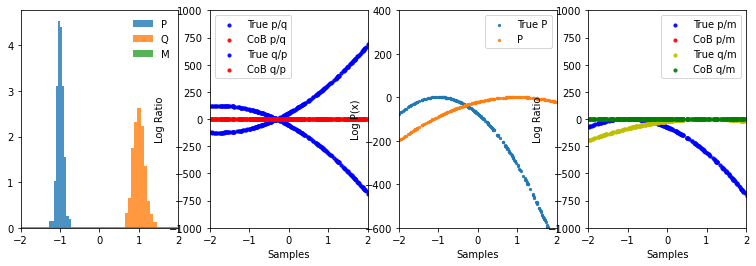

KL :  89.15971
KL from samples :  88.7306
KL from CoB:  0.5355875
Taking 500 samples from prior distributions on weights



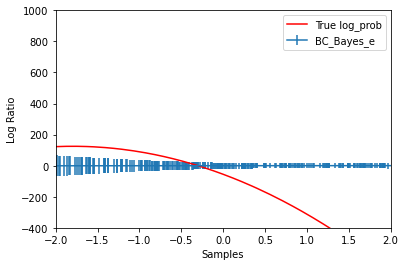

In [ ]:
reset()

mu_1=-1.
mu_2=1.
mu_3=0.
scale_p=0.08
scale_q=0.15
scale_m=2.
N=40000

p, q, m, p_samples, q_samples, m_samples = get_data(mu_1,mu_2,mu_3,scale_p,scale_q,scale_m)
dloss = get_loss(p_samples, q_samples, m_samples)
optim = get_optim(dloss, lr=0.05)

log_ratio_p_q, _, kld = get_gt_ratio_kl(p,q,m_samples)
_, kl_from_pq, _ = get_gt_ratio_kl(p,q,p_samples)
kl_from_cob = get_kl_from_cob(p_samples)

log_ratio_p_m = get_logits(m_samples)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

%matplotlib inline
sample_and_plot(sess, kl_from_pq, kl_from_cob, kld, p_samples, q_samples, m_samples, log_ratio_p_q, log_ratio_p_m, mu_1, mu_2, scale_p, scale_q, mu_3, scale_m, training=False)

In [ ]:
# plotlosses = PlotLosses()
# train(sess, dloss, optim, plotlosses, N=N)


loss_store=[]
fig, [ax1,ax2] = plt.subplots(1, 2,figsize=(10,4))

line, = ax1.plot([0,1],[0,1])
x, y = np.random.random((2, 500))
scat1 = ax2.scatter(x,y,label='True p/q',alpha=0.9,s=10.,c='b')
scat2 = ax2.scatter(x,y,label='CoB p/q',alpha=0.9,s=10.,c='r')

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.set_xlim([0,N])
ax1.set_ylim([0,10])

ax2.set_xlabel("Samples")
ax2.set_ylabel("Log Ratio")
ax2.legend(loc='best')
ax2.set_xlim([mu_1-2,mu_2+2])
ax2.set_ylim([-1000,1000])

plt.tight_layout()

pbar = range(0,N)
for i in pbar:

    feed_dict = {}
    l,_ = sess.run([dloss, optim],feed_dict=feed_dict)
    loss_store.append(l)
    if i%500==0:
        line.set_data(range(len(loss_store)), loss_store)
        xs, lpq, lpqm = sess.run([m_samples, log_ratio_p_q, log_ratio_p_m],feed_dict={})
        scat1.set_offsets(np.asarray([xs, lpq]).T)
        scat2.set_offsets(np.asarray([xs,lpqm[:,0]-lpqm[:,1]]).T)
        
        
        
        clear_output(wait=True)
        display(fig)
        
sample_and_plot(sess, kl_from_pq, kl_from_cob, kld, p_samples, q_samples, m_samples, log_ratio_p_q, log_ratio_p_m, mu_1, mu_2, scale_p, scale_q, mu_3, scale_m)
# with open("../models/kl_utils.py", "a") as f:
#     f.write(" ")
#     f.close()



In [4]:
with open("../models/kl_utils.py", "a") as f:
    f.write(" ")
    f.close()
    

In [9]:
t_vars = tf.trainable_variables()
c_vars = [var for var in t_vars if 'critic' in var.name]

In [10]:
tv = sess.run([c_vars],feed_dict=feed_dict)

In [11]:
tv = [np.float32(x[0]) for x in tv[0]]

In [12]:
tv

[-0.9420838,
 -0.84332186,
 0.8749779,
 0.99371773,
 0.027365789,
 0.038094923,
 1.1597745,
 0.44518286,
 3.8614638,
 -3.9492648,
 1.6647927,
 -0.0069192187,
 -0.1234835,
 -5.4032235]

In [24]:
with tf.variable_scope('critic', reuse=tf.AUTO_REUSE) as scope:
    q1 = tf.get_variable('q1',1.)
    q2 = tf.get_variable('q2',1.)
    q3 = tf.get_variable('q3',1.)
    q4 = tf.get_variable('q4',1.)
    q5 = tf.get_variable('q5',1.)

    b1 = tf.get_variable('b1',1.)
    b2 = tf.get_variable('b2',1.)
    b3 = tf.get_variable('b3',1.)

    s1 = tf.get_variable('s1',1.)
    s2 = tf.get_variable('s2',1.)

    t1 = tf.get_variable('t1',1.)
    t2 = tf.get_variable('t2',1.)
    t3 = tf.get_variable('t3',1.)



tv = sess.run([q1,q2,q3,q4,q5,s1,s2,t1,t2,t3,b1,b2,b3],feed_dict=feed_dict)

In [26]:
tv = [np.float32(x[0]) for x in tv]
print(tv)

[-0.9420838, -0.84332186, 0.8749779, 0.99371773, 0.027365789, 3.8614638, -3.9492648, -0.0069192187, -0.1234835, -5.4032235, 0.038094923, 1.1597745, 0.44518286]


In [19]:
tv

[array([-0.9420838], dtype=float32),
 array([-0.84332186], dtype=float32),
 array([0.8749779], dtype=float32),
 array([0.99371773], dtype=float32),
 array([0.02736579], dtype=float32),
 array([3.8614638], dtype=float32),
 array([-3.9492648], dtype=float32),
 array([-0.00691922], dtype=float32),
 array([-0.1234835], dtype=float32),
 array([-5.4032235], dtype=float32),
 array([0.03809492], dtype=float32),
 array([1.1597745], dtype=float32),
 array([0.44518286], dtype=float32)]